In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from pylab import show

from bokeh.io import show, output_file
from bokeh.plotting import figure, save
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, ColumnDataSource
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

from IPython.display import IFrame

%matplotlib inline

# read in the pickled graph object and dataframes
G = pd.read_pickle("../data/processed/got_graph.gpickle")

edge = pd.read_csv("../data/processed/character_interactions_edge.csv", sep= ",")
node = pd.read_csv("../data/processed/character_interactions_node.csv", sep= ",")

# <span style="color:#0000CD">  Centrality  </span> 

## Objectives:  
### - What is centrality?   
### - Degree centrality  
### - Betweenness centrality

## <span style="color:#0000CD"> What is Centrality? </span>

### Definition

Indicators of centrality (i.e. several methods of measurement) identify the most structurally important nodes within a graph.

## <span style="color:#0000CD"> Degree Centrality </span>

A centrality measure that calculates the number of edges connected to each node (i.e. degree); for a directed graph, a node will have an 'in' degree and an 'out' degree.

**Degree Example:**

Calculate the degree for Lyanna Stark using the graph output below.

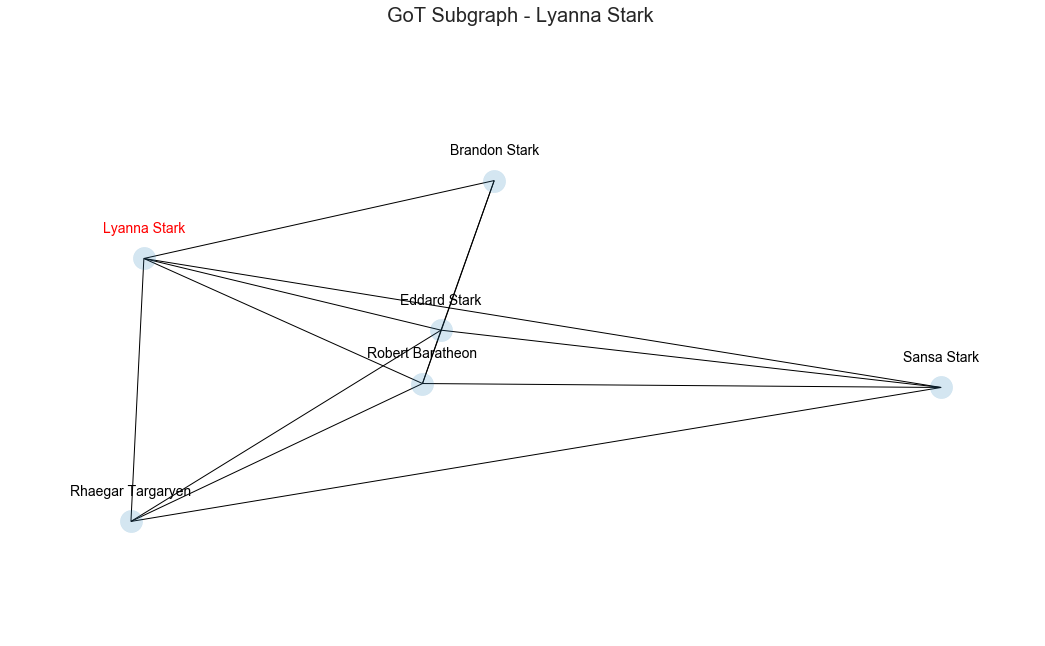

Degree = 5


In [2]:
node='lyanna-stark'
lyanna = list(nx.all_neighbors(G, node))
lyanna.insert(0, node)

G_lyanna = G.subgraph(lyanna)
spring_pos = nx.spring_layout(G, scale=2, center=(0,0))

pos_higher = {}
y_off = 0.006  # offset on the y axis
x_off = 0 # offset on the x axis
for k, v in spring_pos.items():
    pos_higher[k] = (v[0]+x_off, v[1]+y_off)
    
label_lyanna = {key:value for key,value in nx.get_node_attributes(G_lyanna, name='Label').items() if key in lyanna[0]}
label_neighbors = {key:value for key,value in nx.get_node_attributes(G_lyanna, name='Label').items() if key not in lyanna[0]} 

plt.figure(figsize=(18,10), frameon=False)
plt.suptitle('GoT Subgraph - Lyanna Stark', fontsize=20)

nx.draw_networkx_nodes(G_lyanna, pos = spring_pos, node_color=Spectral4[0], alpha=0.2, node_size=500)

nx.draw_networkx_edges(G_lyanna, pos = spring_pos, alpha=1)

nx.draw_networkx_labels(G_lyanna, nodelist = lyanna[0], pos = pos_higher, labels=label_lyanna, font_size = 14, font_color = 'red')
nx.draw_networkx_labels(G_lyanna, nodelist = lyanna[-0], pos = pos_higher, labels=label_neighbors, font_size = 14, font_color = 'black')

plt.autoscale(enable=True, axis='both', tight=True)
plt.axis('off')                       
plt.show()

print("Degree = 5")

### Average Nodal Degree

Computes the average degree over every node in the graph

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ k = 2m/n $ 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *where **m** is the number of edges and **n** is the number of nodes*



** Average Degree Example:**

Let m = 2823 and n = 796. Find the average degree of the graph.

In [3]:
print("Average Nodal Degree (k):")
print(" ")
print("k = 2*(2823)/796")
print(" ")
print("k =",2*(2823)/796)

Average Nodal Degree (k):
 
k = 2*(2823)/796
 
k = 7.092964824120603


In [4]:
print("Graph Summary:")
print(" ")
print(nx.info(G))

Graph Summary:
 
Name: Game of Thrones Character Interactions
Type: Graph
Number of nodes: 796
Number of edges: 2823
Average degree:   7.0930


###  <span style="color:green">  Knowledge Check: </span>

***Is degree a node or edge attribute?***

**Degree Distribution Example**

The histogram gives a visual representation of the spread of degrees across the entire graph where the x-axis is degree value and the y-axis is the number of nodes in that range.

In [5]:
degree = pd.DataFrame(list(G.degree().items()), columns=['Id','Degree'])
degree_sequence = sorted(G.degree().values(),reverse=True)
#degree_sequence_weighted = sorted(G.degree(weight='weight').values(),reverse=True)

h = figure(plot_width=700, 
           plot_height=400, 
          title = "Degree Distribution")

count, bins = np.histogram(degree_sequence, bins = 'auto')
count = np.append(count,[0])
degree_hist = pd.DataFrame(data ={"counts":count, "bins":bins})
source = ColumnDataSource(degree_hist)

h.vbar(x='bins', top='counts', width=3, color="navy", source=source)
h.add_tools(HoverTool(tooltips=[("Value", "@counts")]))

output_file("../img/degree_distribution.html")
save(h)
#Workaround for displaying bokeh
IFrame('../img/degree_distribution.html', width=800, height=450)

In [6]:
print("Degree Summary:")
print(" ")
print(degree.Degree.describe())

Degree Summary:
 
count    796.000000
mean       7.092965
std       12.684618
min        1.000000
25%        2.000000
50%        3.000000
75%        7.000000
max      122.000000
Name: Degree, dtype: float64


###  **Question?**

***What stands out when looking at the degree distribution?***

***Recall our goal is to identify the most popular characters, therefore, we will filter our graph to only show nodes with a degree greater than three and their connecting edges.***

In [7]:
trim = dict((i,j) for i,j in G.degree().items() if j <= 3)

def trimming(G):
 G_trim = G.copy()
 for k, v in G.degree().items():
  if v <= 3:
   G_trim.remove_node(k)
 return G_trim

G_trim = trimming(G)
print("Trimmed Graph Summary:")
print(" ")
print(nx.info(G_trim))

Trimmed Graph Summary:
 
Name: Game of Thrones Character Interactions
Type: Graph
Number of nodes: 377
Number of edges: 2151
Average degree:  11.4111


***Also, recall the long right tail we identified in the Degree Distribution visual. Now we will analyze those characters with a degree greater than or equal to forty to continue pursuing our goal.*** 

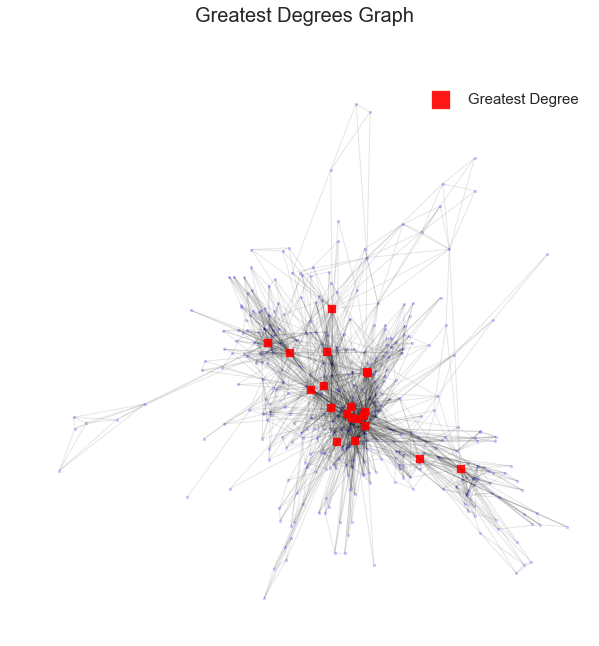

In [8]:
most_popular = dict((i,j) for i,j in G.degree().items() if j >= 40)
G_deg = G_trim.subgraph(most_popular.keys())

plt.figure(figsize=(10,10));
plt.suptitle('Greatest Degrees Graph', fontsize=20)
plt.autoscale(enable=True, axis='both', tight=True)
plt.axis('off')

# create the layout
spring_pos = nx.fruchterman_reingold_layout(G, scale=2, center=(0,0))

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G_trim, pos = spring_pos,
                       node_color='b',
                       alpha=0.2,
                       node_size=8)
nx.draw_networkx_edges(G_trim, pos = spring_pos, 
                       alpha=0.1)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(G_deg, pos = spring_pos,
                       label = 'Greatest Degree',
                       node_color='r',
                       alpha=0.9,
                       node_size=75,
                       node_shape='s')
# also the labels this time
#nx.draw_networkx_labels(G_deg, pos = spring_pos,
                        #font_size=12,
                        #font_color=Spectral4[0])

plt.legend(numpoints=1, loc='best', markerscale=2, fontsize=15)
plt.show()

In [9]:
node_trim = pd.DataFrame([i[1] for i in G_trim.nodes(data=True)], index=[i[0] for i in G_trim.nodes(data=True)])
node_trim = node_trim.reset_index()
node_trim = node_trim.rename(columns = {'index': 'Id'})
node_trim_degree = pd.merge(node_trim, degree, how = 'left', on = ['Id'])
most_popular_df = node_trim_degree[node_trim_degree['Id'].isin(G_deg)]
print("Greatest Degrees Node Table:")
print(" ")
most_popular_df[['Id','Label','Degree']].sort_values(by=['Degree'], ascending = False).reset_index().drop('index',axis=1)

Greatest Degrees Node Table:
 


,Id,Label,Degree
0,tyrion-lannister,Tyrion Lannister,122
1,jon-snow,Jon Snow,114
2,jaime-lannister,Jaime Lannister,101
3,cersei-lannister,Cersei Lannister,97
4,stannis-baratheon,Stannis Baratheon,89
5,arya-stark,Arya Stark,84
6,catelyn-stark,Catelyn Stark,75
7,sansa-stark,Sansa Stark,75
8,robb-stark,Robb Stark,74
9,eddard-stark,Eddard Stark,74


Which character has the highest degree? 

**Tyrion Lannister**

For those who watch the show, this probably comes as no surprise! Tyrion did in fact say, *"I try to know as many people as I can. You never know which one you'll need."* 

For those of you who don't, you might be thinking Tyrion is one popular guy.

### Advantages

- Degree centrality is a relatively simple concept but yields powerful results.  
<br>
- You can gain you information about a particular node or the graph as a whole.

### Disadvantages

- The results can be misleading when not examining the full graph.

## <span style="color:#0000CD"> Betweenness Centrality </span>

A centrality measure that quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
<br>
<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ C_{b}(v) = \sum_{s,t \epsilon V}\frac{\sigma(s,t | v)}{\sigma(s,t)} $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *where **$V$** is the set of nodes, **$\sigma(s,t)$** is the number of shortest paths, and **$\sigma(s,t|v)$** is the number of those paths passing through some node $v$ other than $s,t$*
<br>
<br>
<br>
Consider a pair of nodes, count how many times a node interrupts the shortest path between those two nodes, repeat for every pair of nodes in the graph. Assuming item flow follows shortest paths, a node with a higher betweenness centrality has a large influence on the transfer of items through the network.

**Betweenness Example:**

Given the network below, find betweenness centrality for node $B$ or $C_b(B)$.

<img src="../img/bc.png" width="450">

$AC = \frac{1}{1} = 1$
<br>
<br>
$AD = \frac{1}{1} = 1$
<br>
<br>
$AE = \frac{2}{2} = 1$
<br>
<br>
$CD = \frac{1}{2} = 0.5$
<br>
<br>
$CE = \frac{0}{1} = 0$
<br>
<br>
$DE = \frac{0}{1} = 0$
<br>
<br>
$C_b(B) = 3.5$

***Analyzing the betweenness summary included below for all the nodes in our trimmed graph, we set a threshold to identify the nodes in the top 5%.***   

In [10]:
betweenness = nx.betweenness_centrality(G_trim)
betweenness_df = pd.DataFrame(list(betweenness.items()), columns=['Id','Betweenness'])
node_trim_degree_betweenness = pd.merge(node_trim_degree, betweenness_df, how = 'left', on = ['Id'])
print("Betweenness Summary:")
print(" ")
print(betweenness_df.Betweenness.describe())

print(" ")
def max_betweenness(G):
 ranking = betweenness.items()
 r = [x[1] for x in ranking]
 m = sum(r)/len(r) # mean centrality
 t = m*5 # threshold, we keep only the nodes with 5 times the mean
 print('Threshold:',t)
 Gt = G_trim.copy()
 for k, v in ranking:
  if v < t:
   Gt.remove_node(k)
 return Gt

G_bc = max_betweenness(G_trim)

Betweenness Summary:
 
count    377.000000
mean       0.004919
std        0.017935
min        0.000000
25%        0.000017
50%        0.000161
75%        0.001236
max        0.182016
Name: Betweenness, dtype: float64
 
Threshold: 0.024594879319750913


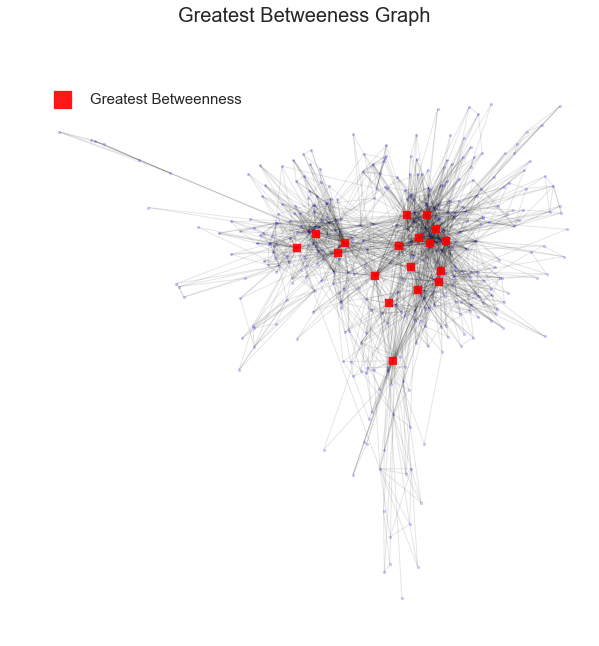

In [11]:
from pylab import show
plt.figure(figsize=(10,10));
plt.suptitle('Greatest Betweeness Graph', fontsize=20)
plt.autoscale(enable=True, axis='both', tight=True)
plt.axis('off')

# create the layout
spring_pos = nx.fruchterman_reingold_layout(G, scale=2, center=(0,0))

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G_trim, pos = spring_pos,
                       node_color='b',
                       alpha=0.2,
                       node_size=8)
nx.draw_networkx_edges(G_trim, pos = spring_pos, 
                       alpha=0.1)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(G_bc, pos = spring_pos,
                       label = 'Greatest Betweenness',
                       node_color='r',
                       alpha=0.9,
                       node_size=75,
                       node_shape='s')
# also the labels this time
#nx.draw_networkx_labels(G_bc, pos = spring_pos,
                        #font_size=12,
                        #font_color=Spectral4[0])

plt.legend(numpoints=1, loc='best', markerscale=2, fontsize=15)
plt.show()

In [12]:
betweenness_centrality_df = node_trim_degree_betweenness[node_trim_degree_betweenness['Id'].isin(G_bc)]
print("Greatest Betweenness Nodes Table:")
print(" ")
betweenness_centrality_df[['Id','Label','Degree','Betweenness']].sort_values(by=['Betweenness'], ascending = False).reset_index().drop('index',axis=1)

Greatest Betweenness Nodes Table:
 


,Id,Label,Degree,Betweenness
0,jon-snow,Jon Snow,114,0.182016
1,tyrion-lannister,Tyrion Lannister,122,0.147212
2,daenerys-targaryen,Daenerys Targaryen,73,0.101606
3,stannis-baratheon,Stannis Baratheon,89,0.098967
4,cersei-lannister,Cersei Lannister,97,0.096565
5,jaime-lannister,Jaime Lannister,101,0.081718
6,robert-baratheon,Robert Baratheon,65,0.079058
7,theon-greyjoy,Theon Greyjoy,66,0.066561
8,arya-stark,Arya Stark,84,0.066026
9,sansa-stark,Sansa Stark,75,0.058324


Which character has the highest betweenness centrality? 

**All hail the King in the Graph!**

<img src="https://media.giphy.com/media/WhQG7vw1JvaeY/giphy.gif" alt="Drawing" style="width: 300px;"/>

Gif cred: [Giphy](https://giphy.com/gifs/jon-snow-WhQG7vw1JvaeY)

### Advantages
- Betweenness centrality gives insights into positioning of nodes in relation to other actors.

### Disadvantages
- The algorithm has a computational complexity of atleast $O(n^3)$ where $n$ is the number of nodes in the graph.

## Types of Centrality

* [Closeness](https://en.wikipedia.org/wiki/Closeness_centrality): a measure of how near an individual is to all other individuals in a graph; the inverse of the sum of the shortest path distances between a node and every other node 
<br>
<br>
* [Eigenvector](http://demonstrations.wolfram.com/NetworkCentralityUsingEigenvectors/): a node's eigenvector centrality is equivalent to the sum of the centrality values of the nodes connected to it
<br>
<br>
* [PageRank](https://cambridge-intelligence.com/eigencentrality-pagerank/): a variant of the Eigenvector measure for a directed network that scores a node's centrality based on the sum of its incoming links, also known as 'The Google Algorithm'
